In [1]:
import numpy as np
import pandas as pd
import os
import re
import glob
from skbio.alignment import local_pairwise_align, TabularMSA
from skbio import Protein
import itertools 
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


In [81]:
def read_fasta(fp):
    name, seq = None, []
    for line in fp:
        line = line.rstrip()
        if line.startswith(">"):
            if name: yield (name, ''.join(seq))
            name, seq = line, []
        else:
            seq.append(line)
    if name: yield (name, ''.join(seq))

def get_sequences(dir):
    files = glob.glob(dir + '/*.fa')
    sequences = []
    for filepath in glob.iglob(os.path.join(dir, "*.fa")):
        with open(filepath) as fp:
            for name, seq in read_fasta(fp):
                sequences.append(seq)
    print("Read in %d fasta files"%len(files))
    return sequences



In [128]:
def get_negpair_seq(filepath, negpairlist_filename):
    '''
    Get sequences for negative pairs.
    Input: Directory for all the sequences
    Output: List of negative pairs sequences
    '''
    files = glob.glob(filepath + '/*.fa')
    negpair_list = open(negpairlist_filename).read().splitlines()
    neg_files, neg_files2 = [],[]
    negpair_sequences, negpair2_sequences  = [], []
    for seq_file in files:
        for negpair in negpair_list:
            if negpair[10:22] in seq_file[-12:]:
                neg_files.append(seq_file)
            if negpair[33:] in seq_file[-12:]:
                neg_files2.append(seq_file)
    for neg_file in neg_files:
        with open(neg_file) as neg:
            for name, neg_seq in read_fasta(neg):
                negpair_sequences.append(neg_seq)
    for neg_file in neg_files2:
        with open(neg_file) as neg:
            for name, neg2_seq in read_fasta(neg):
                negpair2_sequences.append(neg2_seq)
    #Some of the sequences has "x" as a gap. I'm replacing those 'x's with '-'
    #so it works with skbio package. Not really a good way but it works.
    without_x = [s for s in negpair2_sequences if 'x' not in s]
    with_x= [s for s in negpair2_sequences if 'x' in s]
    with_x =' '.join(with_x)
    with_x = with_x.replace('x', '*')
    without_x.append(with_x)
    negpair2_sequences = without_x
    
    print("Read in %d negative pair fasta files" %len(negpair_sequences))
    print("Read in %d negative pair fasta files" %len(negpair2_sequences))
    return negpair_sequences, negpair2_sequences

def get_pospair_seq(filepath,pospairlist_filename):
    '''
    Get sequences for positive pairs.
    Input: Directory for all the sequences
    Output: List of positive pairs sequences
    '''
    files = glob.glob(filepath + '/*.fa')
    pospair_list = open(pospairlist_filename).read().splitlines()
    pos_files,pos2_files = [],[]
    pospair_sequences,pospair2_sequences = [],[]
    for seq_file in files:
        for pospair in pospair_list:
            if pospair[10:22] in seq_file[-12:]:
                pos_files.append(seq_file)
            if pospair[33:] in seq_file[-12:]:
                pos2_files.append(seq_file)
    for pos_file in pos_files:
        with open(pos_file) as pos:
            for name, pos_seq in read_fasta(pos):
                pospair_sequences.append(pos_seq)
    for pos_file in pos2_files:
        with open(pos_file) as pos:
            for name, pos2_seq in read_fasta(pos):
                pospair2_sequences.append(pos2_seq)    
    print("Read in %d positive pair fasta files" %len(pospair_sequences))
    print("Read in %d positive pair fasta files" %len(pospair2_sequences))
    return pospair_sequences, pospair2_sequences

In [93]:
def read_score_matrix(filepath):
    with open(filepath) as mat:
        matrix = mat.read()
        lines = matrix.strip().split('\n')
        score_matrix = []
        for line in lines:
            if not line.startswith("#"):
                score_matrix.append(line)
    aas_column = pd.DataFrame(score_matrix[0].strip().split("  "))
    scores = []
    for i in range(len(score_matrix)-1):
        ls = score_matrix[i+1].strip()
        new = ls.split(" ")
        sub = []
        for n in new:
            if n != "":
                sub.append(int(n))
        scores.append(sub)
        score_df = pd.DataFrame(scores)
        score_df.columns = score_matrix[0].strip().split("  ")
    df_score = aas_column.join(score_df)
    df_score = df_score.set_index([0])
    return df_score
   

                    

In [129]:
directory = '/Users/Snow/Documents/BMI203_Algorithm/HW3_SNaing_2018/sequences/'
negpairlist_filename = '/Users/Snow/Documents/BMI203_Algorithm/HW3_SNaing_2018/Negpairs.txt'
pospairlist_filename = '/Users/Snow/Documents/BMI203_Algorithm/HW3_SNaing_2018/Pospairs.txt'
negpairs1, negpairs2 = get_negpair_seq(directory, negpairlist_filename)
pospairs1, pospairs2 = get_pospair_seq(directory, pospairlist_filename)
blosum50 = read_score_matrix('/Users/Snow/Documents/BMI203_Algorithm/HW3_SNaing_2018/matrices/BLOSUM50')
blosum62 = read_score_matrix('/Users/Snow/Documents/BMI203_Algorithm/HW3_SNaing_2018/matrices/BLOSUM62')
matio = read_score_matrix('/Users/Snow/Documents/BMI203_Algorithm/HW3_SNaing_2018/matrices/MATIO')
pam100 = read_score_matrix('/Users/Snow/Documents/BMI203_Algorithm/HW3_SNaing_2018/matrices/PAM100')
pam250 = read_score_matrix('/Users/Snow/Documents/BMI203_Algorithm/HW3_SNaing_2018/matrices/PAM250')


Read in 50 negative pair fasta files
Read in 50 negative pair fasta files
Read in 50 positive pair fasta files
Read in 50 positive pair fasta files


In [134]:
def align(seq1, seq2, open_penalty, extend_penalty, substitution_matrix):
    '''
    Given two sequences to algin substitution matrix, gap open penalty and
    extend penalty, output the alignment score matrix.

    '''

    # Initialization of score matrix and state state matrix by making an empty matrix.
    # Score Matrix: Matrix with alignment score calulated in each cell
    # State Matrix: Matrix with info on where maximum score is calculated

    mat_score = [[None]*len(seq2) for _ in range(0,len(seq1))]
    mat_state = [[None]*(len(seq2)+1) for _ in range(0,len(seq1)+1)]

    # Set the first row and column of score matrix to zero
#     mat_score[0,:] = 0 
#     mat_score[:,0] = 0 
    mat_score.insert(0,[0] * len(seq2))
    # Set the first column equal to zero
    for row in mat_score:
        row.insert(0,0)
    

#Start scoring matrix by first initializing max score as zero and 
#replacing the max score by calculating deletion, insertion or match/mismatch
#score by getting scores from left, right and diagonal respectively. 
#And also, update the state as we calculate the score.     
    for i in range(1,len(seq1)+1):
        for j in range(1, len(seq2)+1):        
            max_score = 0
            state = ""

# Calculate left well deletion score by determining whether it is
#gap open or extension and update the new score if the score calculated 
#is greater than zero

            if mat_state[i][j-1] == "del":
                score = mat_score[i][j-1] + extend_penalty
            else:
                score = mat_score[i][j-1] + open_penalty

            if score > max_score:
                max_score = score
                state = "del"

# Calculate up well insertion score by determining whether it is
#gap open or extension and update the new score if the score calculated 
#is greater than zero            
            if mat_state[i-1][j] == "ins":
                score = mat_score[i-1][j] + extend_penalty
            else:
                score = mat_score[i-1][j] + open_penalty

            if score > max_score:
                max_score = score
                state = "ins"

# Calculate diagonal well alignment score by reffering to substitution
#matrix 
            aa_i = seq1[i-1]
            aa_j = seq2[j-1]
            align_score = substitution_matrix.loc[str(aa_i),str(aa_j)]
            score = mat_score[i-1][j-1] + align_score
            if score > max_score:
                max_score = score
                state = "align"

            mat_score[i][j] = max_score
            mat_state[i][j] = state

    return np.asarray(mat_score), np.asanyarray(mat_state), max_score, state

# Finding best gap panalties scores at TPR = 0.7 for BLOSUM50

In [135]:
possible_gap_extend_penalties = list(range(1,6))
possible_gap_open_penalties = list(range(1,21))
best_fpr = float('inf')
best_gap = None
best_extension = None

for open_penalty in possible_gap_open_penalties: 
    for extend_penalty in possible_gap_extend_penalties:
        print ("At open penalty score " + str(open_penalty) + " and extend penalty "+ str(extend_penalty))
        pos_align_score = []
        neg_align_score = []
        for i in range(0,len(pospairs1)):
            mat_score_p,mat_state_p, score_p, state_p = align(pospairs1[i],pospairs2[i], -open_penalty,-extend_penalty, blosum50)
            print ("In " + str(i) + " Pospair: score_p is " + str(score_p))
            mat_score_n,mat_state_n, score_n, state_n = align(negpairs1[i],negpairs2[i], -open_penalty,-extend_penalty, blosum50)
            print ("In " + str(i) + " Negpair: score_n is " + str(score_n))
            pos_align_score.append(score_p)
            neg_align_score.append(score_n)
        pos_align_score.sort()
        neg_align_score.sort()
        tpr = 0.7 #tpr = #>thresh / total scores
        cutoff_index = int((1-tpr)*len(pos_align_score))# find the index that makes it so tpr*lenscores is > threshold
        threshold = pos_align_score[cutoff_index]
        neg_score_np = np.array(neg_align_score)
        fpr = len(neg_score_np[neg_score_np > threshold])/len(neg_score_np) #False Positive Rate
        if fpr < best_fpr:
            best_fpr = fpr
            best_gap = open_penalty
            best_extension = extend_penalty
            
            print ("Best gap now is " + str(best_gap))
            print ("Best extend now is "+ str(best_extension))
    
print('Best Open and extension gap penalty scores are %d and %d.' % (best_gap,best_extension))
print('Best False positive rate is %d.' %(best_fpr))
            
            

At open penalty score 1 and extend penalty 1
In 0 Pospair: score_p is 307
In 0 Negpair: score_n is 114
In 1 Pospair: score_p is 265
In 1 Negpair: score_n is 112
In 2 Pospair: score_p is 298
In 2 Negpair: score_n is 206
In 3 Pospair: score_p is 360
In 3 Negpair: score_n is 204
In 4 Pospair: score_p is 305
In 4 Negpair: score_n is 153
In 5 Pospair: score_p is 274
In 5 Negpair: score_n is 49
In 6 Pospair: score_p is 161
In 6 Negpair: score_n is 165
In 7 Pospair: score_p is 589
In 7 Negpair: score_n is 438
In 8 Pospair: score_p is 95
In 8 Negpair: score_n is 64
In 9 Pospair: score_p is 224
In 9 Negpair: score_n is 151
In 10 Pospair: score_p is 261
In 10 Negpair: score_n is 327
In 11 Pospair: score_p is 161
In 11 Negpair: score_n is 417
In 12 Pospair: score_p is 165
In 12 Negpair: score_n is 138
In 13 Pospair: score_p is 187
In 13 Negpair: score_n is 60
In 14 Pospair: score_p is 185
In 14 Negpair: score_n is 171
In 15 Pospair: score_p is 450
In 15 Negpair: score_n is 296
In 16 Pospair: scor

In 36 Pospair: score_p is 222
In 36 Negpair: score_n is 274
In 37 Pospair: score_p is 129
In 37 Negpair: score_n is 172
In 38 Pospair: score_p is 32
In 38 Negpair: score_n is 390
In 39 Pospair: score_p is 299
In 39 Negpair: score_n is 142
In 40 Pospair: score_p is 196
In 40 Negpair: score_n is 171
In 41 Pospair: score_p is 172
In 41 Negpair: score_n is 152
In 42 Pospair: score_p is 157
In 42 Negpair: score_n is 114
In 43 Pospair: score_p is 147
In 43 Negpair: score_n is 22
In 44 Pospair: score_p is 188
In 44 Negpair: score_n is 101
In 45 Pospair: score_p is 115
In 45 Negpair: score_n is 56
In 46 Pospair: score_p is 206
In 46 Negpair: score_n is 104
In 47 Pospair: score_p is 136
In 47 Negpair: score_n is 100
In 48 Pospair: score_p is 309
In 48 Negpair: score_n is 116
In 49 Pospair: score_p is 156
In 49 Negpair: score_n is 417
At open penalty score 1 and extend penalty 4
In 0 Pospair: score_p is 210
In 0 Negpair: score_n is 73
In 1 Pospair: score_p is 169
In 1 Negpair: score_n is 83
In 2

In 22 Negpair: score_n is 232
In 23 Pospair: score_p is 154
In 23 Negpair: score_n is 95
In 24 Pospair: score_p is 268
In 24 Negpair: score_n is 246
In 25 Pospair: score_p is 274
In 25 Negpair: score_n is 55
In 26 Pospair: score_p is 74
In 26 Negpair: score_n is 169
In 27 Pospair: score_p is 309
In 27 Negpair: score_n is 109
In 28 Pospair: score_p is 295
In 28 Negpair: score_n is 66
In 29 Pospair: score_p is 444
In 29 Negpair: score_n is 117
In 30 Pospair: score_p is 237
In 30 Negpair: score_n is 96
In 31 Pospair: score_p is 1610
In 31 Negpair: score_n is 326
In 32 Pospair: score_p is 430
In 32 Negpair: score_n is 167
In 33 Pospair: score_p is 316
In 33 Negpair: score_n is 245
In 34 Pospair: score_p is 209
In 34 Negpair: score_n is 152
In 35 Pospair: score_p is 146
In 35 Negpair: score_n is 202
In 36 Pospair: score_p is 220
In 36 Negpair: score_n is 274
In 37 Pospair: score_p is 141
In 37 Negpair: score_n is 189
In 38 Pospair: score_p is 55
In 38 Negpair: score_n is 384
In 39 Pospair: 

In 10 Pospair: score_p is 148
In 10 Negpair: score_n is 142
In 11 Pospair: score_p is 90
In 11 Negpair: score_n is 210
In 12 Pospair: score_p is 64
In 12 Negpair: score_n is 73
In 13 Pospair: score_p is 104
In 13 Negpair: score_n is 19
In 14 Pospair: score_p is 67
In 14 Negpair: score_n is 85
In 15 Pospair: score_p is 239
In 15 Negpair: score_n is 119
In 16 Pospair: score_p is 119
In 16 Negpair: score_n is 224
In 17 Pospair: score_p is 170
In 17 Negpair: score_n is 48
In 18 Pospair: score_p is 134
In 18 Negpair: score_n is 63
In 19 Pospair: score_p is 71
In 19 Negpair: score_n is 39
In 20 Pospair: score_p is 152
In 20 Negpair: score_n is 273
In 21 Pospair: score_p is 182
In 21 Negpair: score_n is 105
In 22 Pospair: score_p is 123
In 22 Negpair: score_n is 152
In 23 Pospair: score_p is 95
In 23 Negpair: score_n is 57
In 24 Pospair: score_p is 210
In 24 Negpair: score_n is 173
In 25 Pospair: score_p is 133
In 25 Negpair: score_n is 27
In 26 Pospair: score_p is 60
In 26 Negpair: score_n i

In 47 Negpair: score_n is 84
In 48 Pospair: score_p is 293
In 48 Negpair: score_n is 106
In 49 Pospair: score_p is 149
In 49 Negpair: score_n is 354
At open penalty score 3 and extend penalty 2
In 0 Pospair: score_p is 162
In 0 Negpair: score_n is 49
In 1 Pospair: score_p is 107
In 1 Negpair: score_n is 39
In 2 Pospair: score_p is 148
In 2 Negpair: score_n is 107
In 3 Pospair: score_p is 168
In 3 Negpair: score_n is 118
In 4 Pospair: score_p is 165
In 4 Negpair: score_n is 80
In 5 Pospair: score_p is 127
In 5 Negpair: score_n is 10
In 6 Pospair: score_p is 80
In 6 Negpair: score_n is 68
In 7 Pospair: score_p is 312
In 7 Negpair: score_n is 201
In 8 Pospair: score_p is 52
In 8 Negpair: score_n is 35
In 9 Pospair: score_p is 105
In 9 Negpair: score_n is 66
In 10 Pospair: score_p is 135
In 10 Negpair: score_n is 157
In 11 Pospair: score_p is 80
In 11 Negpair: score_n is 195
In 12 Pospair: score_p is 63
In 12 Negpair: score_n is 73
In 13 Pospair: score_p is 96
In 13 Negpair: score_n is 20


In 35 Negpair: score_n is 106
In 36 Pospair: score_p is 114
In 36 Negpair: score_n is 141
In 37 Pospair: score_p is 69
In 37 Negpair: score_n is 84
In 38 Pospair: score_p is 9
In 38 Negpair: score_n is 180
In 39 Pospair: score_p is 155
In 39 Negpair: score_n is 61
In 40 Pospair: score_p is 89
In 40 Negpair: score_n is 91
In 41 Pospair: score_p is 82
In 41 Negpair: score_n is 65
In 42 Pospair: score_p is 76
In 42 Negpair: score_n is 53
In 43 Pospair: score_p is 74
In 43 Negpair: score_n is 1
In 44 Pospair: score_p is 87
In 44 Negpair: score_n is 50
In 45 Pospair: score_p is 53
In 45 Negpair: score_n is 19
In 46 Pospair: score_p is 80
In 46 Negpair: score_n is 54
In 47 Pospair: score_p is 65
In 47 Negpair: score_n is 52
In 48 Pospair: score_p is 156
In 48 Negpair: score_n is 44
In 49 Pospair: score_p is 66
In 49 Negpair: score_n is 151
At open penalty score 3 and extend penalty 5
In 0 Pospair: score_p is 117
In 0 Negpair: score_n is 39
In 1 Pospair: score_p is 69
In 1 Negpair: score_n is

In 24 Pospair: score_p is 150
In 24 Negpair: score_n is 133
In 25 Pospair: score_p is 120
In 25 Negpair: score_n is 17
In 26 Pospair: score_p is 41
In 26 Negpair: score_n is 73
In 27 Pospair: score_p is 138
In 27 Negpair: score_n is 51
In 28 Pospair: score_p is 119
In 28 Negpair: score_n is 17
In 29 Pospair: score_p is 224
In 29 Negpair: score_n is 59
In 30 Pospair: score_p is 90
In 30 Negpair: score_n is 56
In 31 Pospair: score_p is 1610
In 31 Negpair: score_n is 170
In 32 Pospair: score_p is 230
In 32 Negpair: score_n is 82
In 33 Pospair: score_p is 146
In 33 Negpair: score_n is 132
In 34 Pospair: score_p is 84
In 34 Negpair: score_n is 91
In 35 Pospair: score_p is 75
In 35 Negpair: score_n is 88
In 36 Pospair: score_p is 108
In 36 Negpair: score_n is 132
In 37 Pospair: score_p is 64
In 37 Negpair: score_n is 81
In 38 Pospair: score_p is 9
In 38 Negpair: score_n is 179
In 39 Pospair: score_p is 151
In 39 Negpair: score_n is 57
In 40 Pospair: score_p is 84
In 40 Negpair: score_n is 10

In 14 Pospair: score_p is 15
In 14 Negpair: score_n is 17
In 15 Pospair: score_p is 101
In 15 Negpair: score_n is 52
In 16 Pospair: score_p is 41
In 16 Negpair: score_n is 88
In 17 Pospair: score_p is 84
In 17 Negpair: score_n is 19
In 18 Pospair: score_p is 67
In 18 Negpair: score_n is 23
In 19 Pospair: score_p is 30
In 19 Negpair: score_n is 19
In 20 Pospair: score_p is 74
In 20 Negpair: score_n is 138
In 21 Pospair: score_p is 91
In 21 Negpair: score_n is 49
In 22 Pospair: score_p is 54
In 22 Negpair: score_n is 70
In 23 Pospair: score_p is 48
In 23 Negpair: score_n is 30
In 24 Pospair: score_p is 118
In 24 Negpair: score_n is 81
In 25 Pospair: score_p is 56
In 25 Negpair: score_n is 17
In 26 Pospair: score_p is 38
In 26 Negpair: score_n is 37
In 27 Pospair: score_p is 44
In 27 Negpair: score_n is 15
In 28 Pospair: score_p is 60
In 28 Negpair: score_n is 0
In 29 Pospair: score_p is 137
In 29 Negpair: score_n is 44
In 30 Pospair: score_p is 63
In 30 Negpair: score_n is 36
In 31 Pospa

In 3 Pospair: score_p is 49
In 3 Negpair: score_n is 64
In 4 Pospair: score_p is 67
In 4 Negpair: score_n is 25
In 5 Pospair: score_p is 40
In 5 Negpair: score_n is 7
In 6 Pospair: score_p is 51
In 6 Negpair: score_n is 5
In 7 Pospair: score_p is 141
In 7 Negpair: score_n is 102
In 8 Pospair: score_p is 28
In 8 Negpair: score_n is 17
In 9 Pospair: score_p is 43
In 9 Negpair: score_n is 13
In 10 Pospair: score_p is 51
In 10 Negpair: score_n is 66
In 11 Pospair: score_p is 44
In 11 Negpair: score_n is 73
In 12 Pospair: score_p is 4
In 12 Negpair: score_n is 40
In 13 Pospair: score_p is 34
In 13 Negpair: score_n is 1
In 14 Pospair: score_p is 12
In 14 Negpair: score_n is 14
In 15 Pospair: score_p is 94
In 15 Negpair: score_n is 52
In 16 Pospair: score_p is 31
In 16 Negpair: score_n is 81
In 17 Pospair: score_p is 67
In 17 Negpair: score_n is 14
In 18 Pospair: score_p is 55
In 18 Negpair: score_n is 15
In 19 Pospair: score_p is 20
In 19 Negpair: score_n is 13
In 20 Pospair: score_p is 56
I

In 44 Pospair: score_p is 16
In 44 Negpair: score_n is 14
In 45 Pospair: score_p is 18
In 45 Negpair: score_n is 1
In 46 Pospair: score_p is 26
In 46 Negpair: score_n is 25
In 47 Pospair: score_p is 15
In 47 Negpair: score_n is 19
In 48 Pospair: score_p is 68
In 48 Negpair: score_n is 9
In 49 Pospair: score_p is 21
In 49 Negpair: score_n is 18
At open penalty score 6 and extend penalty 1
In 0 Pospair: score_p is 112
In 0 Negpair: score_n is 21
In 1 Pospair: score_p is 65
In 1 Negpair: score_n is 19
In 2 Pospair: score_p is 81
In 2 Negpair: score_n is 62
In 3 Pospair: score_p is 105
In 3 Negpair: score_n is 84
In 4 Pospair: score_p is 92
In 4 Negpair: score_n is 38
In 5 Pospair: score_p is 67
In 5 Negpair: score_n is 7
In 6 Pospair: score_p is 58
In 6 Negpair: score_n is 41
In 7 Pospair: score_p is 187
In 7 Negpair: score_n is 118
In 8 Pospair: score_p is 28
In 8 Negpair: score_n is 20
In 9 Pospair: score_p is 64
In 9 Negpair: score_n is 33
In 10 Pospair: score_p is 75
In 10 Negpair: sc

In 34 Negpair: score_n is 50
In 35 Pospair: score_p is 33
In 35 Negpair: score_n is 34
In 36 Pospair: score_p is 32
In 36 Negpair: score_n is 55
In 37 Pospair: score_p is 26
In 37 Negpair: score_n is 28
In 38 Pospair: score_p is 1
In 38 Negpair: score_n is 51
In 39 Pospair: score_p is 61
In 39 Negpair: score_n is 12
In 40 Pospair: score_p is 22
In 40 Negpair: score_n is 44
In 41 Pospair: score_p is 31
In 41 Negpair: score_n is 15
In 42 Pospair: score_p is 26
In 42 Negpair: score_n is 14
In 43 Pospair: score_p is 34
In 43 Negpair: score_n is 0
In 44 Pospair: score_p is 31
In 44 Negpair: score_n is 18
In 45 Pospair: score_p is 21
In 45 Negpair: score_n is 2
In 46 Pospair: score_p is 24
In 46 Negpair: score_n is 20
In 47 Pospair: score_p is 17
In 47 Negpair: score_n is 28
In 48 Pospair: score_p is 62
In 48 Negpair: score_n is 8
In 49 Pospair: score_p is 23
In 49 Negpair: score_n is 26
At open penalty score 6 and extend penalty 4
In 0 Pospair: score_p is 58
In 0 Negpair: score_n is 10
In 1

In 27 Pospair: score_p is 92
In 27 Negpair: score_n is 38
In 28 Pospair: score_p is 68
In 28 Negpair: score_n is 9
In 29 Pospair: score_p is 126
In 29 Negpair: score_n is 47
In 30 Pospair: score_p is 60
In 30 Negpair: score_n is 31
In 31 Pospair: score_p is 1610
In 31 Negpair: score_n is 92
In 32 Pospair: score_p is 142
In 32 Negpair: score_n is 51
In 33 Pospair: score_p is 80
In 33 Negpair: score_n is 85
In 34 Pospair: score_p is 67
In 34 Negpair: score_n is 59
In 35 Pospair: score_p is 45
In 35 Negpair: score_n is 41
In 36 Pospair: score_p is 47
In 36 Negpair: score_n is 85
In 37 Pospair: score_p is 41
In 37 Negpair: score_n is 45
In 38 Pospair: score_p is 5
In 38 Negpair: score_n is 91
In 39 Pospair: score_p is 108
In 39 Negpair: score_n is 28
In 40 Pospair: score_p is 51
In 40 Negpair: score_n is 65
In 41 Pospair: score_p is 47
In 41 Negpair: score_n is 54
In 42 Pospair: score_p is 44
In 42 Negpair: score_n is 20
In 43 Pospair: score_p is 47
In 43 Negpair: score_n is 7
In 44 Pospai

In 19 Negpair: score_n is 4
In 20 Pospair: score_p is 19
In 20 Negpair: score_n is 52
In 21 Pospair: score_p is 19
In 21 Negpair: score_n is 10
In 22 Pospair: score_p is 12
In 22 Negpair: score_n is 17
In 23 Pospair: score_p is 18
In 23 Negpair: score_n is 6
In 24 Pospair: score_p is 53
In 24 Negpair: score_n is 19
In 25 Pospair: score_p is 3
In 25 Negpair: score_n is 11
In 26 Pospair: score_p is 22
In 26 Negpair: score_n is 7
In 27 Pospair: score_p is 0
In 27 Negpair: score_n is 9
In 28 Pospair: score_p is 0
In 28 Negpair: score_n is 0
In 29 Pospair: score_p is 30
In 29 Negpair: score_n is 24
In 30 Pospair: score_p is 16
In 30 Negpair: score_n is 15
In 31 Pospair: score_p is 1610
In 31 Negpair: score_n is 22
In 32 Pospair: score_p is 37
In 32 Negpair: score_n is 10
In 33 Pospair: score_p is 1
In 33 Negpair: score_n is 27
In 34 Pospair: score_p is 15
In 34 Negpair: score_n is 39
In 35 Pospair: score_p is 11
In 35 Negpair: score_n is 18
In 36 Pospair: score_p is 10
In 36 Negpair: score_

In 11 Negpair: score_n is 14
In 12 Pospair: score_p is 0
In 12 Negpair: score_n is 23
In 13 Pospair: score_p is 0
In 13 Negpair: score_n is 0
In 14 Pospair: score_p is 4
In 14 Negpair: score_n is 7
In 15 Pospair: score_p is 39
In 15 Negpair: score_n is 25
In 16 Pospair: score_p is 0
In 16 Negpair: score_n is 21
In 17 Pospair: score_p is 24
In 17 Negpair: score_n is 2
In 18 Pospair: score_p is 27
In 18 Negpair: score_n is 1
In 19 Pospair: score_p is 11
In 19 Negpair: score_n is 3
In 20 Pospair: score_p is 17
In 20 Negpair: score_n is 65
In 21 Pospair: score_p is 13
In 21 Negpair: score_n is 10
In 22 Pospair: score_p is 20
In 22 Negpair: score_n is 21
In 23 Pospair: score_p is 22
In 23 Negpair: score_n is 10
In 24 Pospair: score_p is 75
In 24 Negpair: score_n is 32
In 25 Pospair: score_p is 21
In 25 Negpair: score_n is 9
In 26 Pospair: score_p is 26
In 26 Negpair: score_n is 10
In 27 Pospair: score_p is 25
In 27 Negpair: score_n is 16
In 28 Pospair: score_p is 16
In 28 Negpair: score_n i

In 4 Pospair: score_p is 0
In 4 Negpair: score_n is 1
In 5 Pospair: score_p is 3
In 5 Negpair: score_n is 4
In 6 Pospair: score_p is 36
In 6 Negpair: score_n is 5
In 7 Pospair: score_p is 5
In 7 Negpair: score_n is 8
In 8 Pospair: score_p is 0
In 8 Negpair: score_n is 0
In 9 Pospair: score_p is 2
In 9 Negpair: score_n is 0
In 10 Pospair: score_p is 9
In 10 Negpair: score_n is 4
In 11 Pospair: score_p is 2
In 11 Negpair: score_n is 0
In 12 Pospair: score_p is 0
In 12 Negpair: score_n is 7
In 13 Pospair: score_p is 0
In 13 Negpair: score_n is 0
In 14 Pospair: score_p is 4
In 14 Negpair: score_n is 4
In 15 Pospair: score_p is 5
In 15 Negpair: score_n is 9
In 16 Pospair: score_p is 0
In 16 Negpair: score_n is 0
In 17 Pospair: score_p is 0
In 17 Negpair: score_n is 0
In 18 Pospair: score_p is 17
In 18 Negpair: score_n is 0
In 19 Pospair: score_p is 9
In 19 Negpair: score_n is 0
In 20 Pospair: score_p is 7
In 20 Negpair: score_n is 40
In 21 Pospair: score_p is 0
In 21 Negpair: score_n is 10


In 47 Negpair: score_n is 21
In 48 Pospair: score_p is 36
In 48 Negpair: score_n is 5
In 49 Pospair: score_p is 9
In 49 Negpair: score_n is 0
At open penalty score 9 and extend penalty 3
In 0 Pospair: score_p is 18
In 0 Negpair: score_n is 6
In 1 Pospair: score_p is 11
In 1 Negpair: score_n is 4
In 2 Pospair: score_p is 5
In 2 Negpair: score_n is 9
In 3 Pospair: score_p is 3
In 3 Negpair: score_n is 19
In 4 Pospair: score_p is 0
In 4 Negpair: score_n is 1
In 5 Pospair: score_p is 1
In 5 Negpair: score_n is 3
In 6 Pospair: score_p is 32
In 6 Negpair: score_n is 5
In 7 Pospair: score_p is 4
In 7 Negpair: score_n is 8
In 8 Pospair: score_p is 1
In 8 Negpair: score_n is 1
In 9 Pospair: score_p is 2
In 9 Negpair: score_n is 0
In 10 Pospair: score_p is 6
In 10 Negpair: score_n is 4
In 11 Pospair: score_p is 0
In 11 Negpair: score_n is 0
In 12 Pospair: score_p is 0
In 12 Negpair: score_n is 10
In 13 Pospair: score_p is 0
In 13 Negpair: score_n is 0
In 14 Pospair: score_p is 4
In 14 Negpair: s

In 41 Negpair: score_n is 0
In 42 Pospair: score_p is 12
In 42 Negpair: score_n is 9
In 43 Pospair: score_p is 7
In 43 Negpair: score_n is 0
In 44 Pospair: score_p is 0
In 44 Negpair: score_n is 2
In 45 Pospair: score_p is 4
In 45 Negpair: score_n is 0
In 46 Pospair: score_p is 2
In 46 Negpair: score_n is 0
In 47 Pospair: score_p is 0
In 47 Negpair: score_n is 4
In 48 Pospair: score_p is 10
In 48 Negpair: score_n is 5
In 49 Pospair: score_p is 0
In 49 Negpair: score_n is 0
At open penalty score 10 and extend penalty 1
In 0 Pospair: score_p is 38
In 0 Negpair: score_n is 7
In 1 Pospair: score_p is 11
In 1 Negpair: score_n is 4
In 2 Pospair: score_p is 18
In 2 Negpair: score_n is 12
In 3 Pospair: score_p is 6
In 3 Negpair: score_n is 38
In 4 Pospair: score_p is 18
In 4 Negpair: score_n is 2
In 5 Pospair: score_p is 12
In 5 Negpair: score_n is 2
In 6 Pospair: score_p is 30
In 6 Negpair: score_n is 5
In 7 Pospair: score_p is 44
In 7 Negpair: score_n is 34
In 8 Pospair: score_p is 7
In 8 Ne

In 34 Negpair: score_n is 22
In 35 Pospair: score_p is 4
In 35 Negpair: score_n is 13
In 36 Pospair: score_p is 0
In 36 Negpair: score_n is 8
In 37 Pospair: score_p is 12
In 37 Negpair: score_n is 0
In 38 Pospair: score_p is 0
In 38 Negpair: score_n is 0
In 39 Pospair: score_p is 11
In 39 Negpair: score_n is 3
In 40 Pospair: score_p is 7
In 40 Negpair: score_n is 8
In 41 Pospair: score_p is 1
In 41 Negpair: score_n is 0
In 42 Pospair: score_p is 11
In 42 Negpair: score_n is 9
In 43 Pospair: score_p is 5
In 43 Negpair: score_n is 0
In 44 Pospair: score_p is 1
In 44 Negpair: score_n is 1
In 45 Pospair: score_p is 3
In 45 Negpair: score_n is 0
In 46 Pospair: score_p is 2
In 46 Negpair: score_n is 0
In 47 Pospair: score_p is 0
In 47 Negpair: score_n is 4
In 48 Pospair: score_p is 19
In 48 Negpair: score_n is 4
In 49 Pospair: score_p is 0
In 49 Negpair: score_n is 0
At open penalty score 10 and extend penalty 4
In 0 Pospair: score_p is 15
In 0 Negpair: score_n is 4
In 1 Pospair: score_p is 

In 29 Pospair: score_p is 13
In 29 Negpair: score_n is 24
In 30 Pospair: score_p is 25
In 30 Negpair: score_n is 8
In 31 Pospair: score_p is 1610
In 31 Negpair: score_n is 0
In 32 Pospair: score_p is 38
In 32 Negpair: score_n is 7
In 33 Pospair: score_p is 7
In 33 Negpair: score_n is 29
In 34 Pospair: score_p is 11
In 34 Negpair: score_n is 26
In 35 Pospair: score_p is 6
In 35 Negpair: score_n is 12
In 36 Pospair: score_p is 0
In 36 Negpair: score_n is 37
In 37 Pospair: score_p is 17
In 37 Negpair: score_n is 0
In 38 Pospair: score_p is 0
In 38 Negpair: score_n is 10
In 39 Pospair: score_p is 24
In 39 Negpair: score_n is 2
In 40 Pospair: score_p is 7
In 40 Negpair: score_n is 18
In 41 Pospair: score_p is 1
In 41 Negpair: score_n is 2
In 42 Pospair: score_p is 22
In 42 Negpair: score_n is 9
In 43 Pospair: score_p is 9
In 43 Negpair: score_n is 0
In 44 Pospair: score_p is 15
In 44 Negpair: score_n is 0
In 45 Pospair: score_p is 5
In 45 Negpair: score_n is 0
In 46 Pospair: score_p is 4
In

In 23 Pospair: score_p is 1
In 23 Negpair: score_n is 0
In 24 Pospair: score_p is 35
In 24 Negpair: score_n is 9
In 25 Pospair: score_p is 0
In 25 Negpair: score_n is 3
In 26 Pospair: score_p is 9
In 26 Negpair: score_n is 3
In 27 Pospair: score_p is 0
In 27 Negpair: score_n is 9
In 28 Pospair: score_p is 0
In 28 Negpair: score_n is 0
In 29 Pospair: score_p is 0
In 29 Negpair: score_n is 12
In 30 Pospair: score_p is 13
In 30 Negpair: score_n is 3
In 31 Pospair: score_p is 1610
In 31 Negpair: score_n is 0
In 32 Pospair: score_p is 1
In 32 Negpair: score_n is 5
In 33 Pospair: score_p is 0
In 33 Negpair: score_n is 4
In 34 Pospair: score_p is 0
In 34 Negpair: score_n is 11
In 35 Pospair: score_p is 4
In 35 Negpair: score_n is 12
In 36 Pospair: score_p is 0
In 36 Negpair: score_n is 6
In 37 Pospair: score_p is 12
In 37 Negpair: score_n is 0
In 38 Pospair: score_p is 0
In 38 Negpair: score_n is 0
In 39 Pospair: score_p is 5
In 39 Negpair: score_n is 2
In 40 Pospair: score_p is 7
In 40 Negpa

In 17 Pospair: score_p is 0
In 17 Negpair: score_n is 0
In 18 Pospair: score_p is 12
In 18 Negpair: score_n is 0
In 19 Pospair: score_p is 5
In 19 Negpair: score_n is 0
In 20 Pospair: score_p is 1
In 20 Negpair: score_n is 26
In 21 Pospair: score_p is 0
In 21 Negpair: score_n is 10
In 22 Pospair: score_p is 7
In 22 Negpair: score_n is 14
In 23 Pospair: score_p is 1
In 23 Negpair: score_n is 0
In 24 Pospair: score_p is 41
In 24 Negpair: score_n is 8
In 25 Pospair: score_p is 0
In 25 Negpair: score_n is 3
In 26 Pospair: score_p is 14
In 26 Negpair: score_n is 6
In 27 Pospair: score_p is 0
In 27 Negpair: score_n is 9
In 28 Pospair: score_p is 0
In 28 Negpair: score_n is 0
In 29 Pospair: score_p is 0
In 29 Negpair: score_n is 17
In 30 Pospair: score_p is 13
In 30 Negpair: score_n is 2
In 31 Pospair: score_p is 1610
In 31 Negpair: score_n is 0
In 32 Pospair: score_p is 7
In 32 Negpair: score_n is 5
In 33 Pospair: score_p is 0
In 33 Negpair: score_n is 9
In 34 Pospair: score_p is 0
In 34 Neg

In 11 Negpair: score_n is 0
In 12 Pospair: score_p is 0
In 12 Negpair: score_n is 3
In 13 Pospair: score_p is 0
In 13 Negpair: score_n is 0
In 14 Pospair: score_p is 4
In 14 Negpair: score_n is 2
In 15 Pospair: score_p is 0
In 15 Negpair: score_n is 9
In 16 Pospair: score_p is 0
In 16 Negpair: score_n is 0
In 17 Pospair: score_p is 0
In 17 Negpair: score_n is 0
In 18 Pospair: score_p is 2
In 18 Negpair: score_n is 0
In 19 Pospair: score_p is 5
In 19 Negpair: score_n is 0
In 20 Pospair: score_p is 1
In 20 Negpair: score_n is 11
In 21 Pospair: score_p is 0
In 21 Negpair: score_n is 10
In 22 Pospair: score_p is 7
In 22 Negpair: score_n is 14
In 23 Pospair: score_p is 0
In 23 Negpair: score_n is 0
In 24 Pospair: score_p is 30
In 24 Negpair: score_n is 8
In 25 Pospair: score_p is 0
In 25 Negpair: score_n is 3
In 26 Pospair: score_p is 3
In 26 Negpair: score_n is 2
In 27 Pospair: score_p is 0
In 27 Negpair: score_n is 9
In 28 Pospair: score_p is 0
In 28 Negpair: score_n is 0
In 29 Pospair: s

In 7 Pospair: score_p is 4
In 7 Negpair: score_n is 3
In 8 Pospair: score_p is 0
In 8 Negpair: score_n is 0
In 9 Pospair: score_p is 2
In 9 Negpair: score_n is 0
In 10 Pospair: score_p is 2
In 10 Negpair: score_n is 4
In 11 Pospair: score_p is 0
In 11 Negpair: score_n is 0
In 12 Pospair: score_p is 0
In 12 Negpair: score_n is 2
In 13 Pospair: score_p is 0
In 13 Negpair: score_n is 0
In 14 Pospair: score_p is 4
In 14 Negpair: score_n is 2
In 15 Pospair: score_p is 0
In 15 Negpair: score_n is 9
In 16 Pospair: score_p is 0
In 16 Negpair: score_n is 0
In 17 Pospair: score_p is 0
In 17 Negpair: score_n is 0
In 18 Pospair: score_p is 6
In 18 Negpair: score_n is 0
In 19 Pospair: score_p is 4
In 19 Negpair: score_n is 0
In 20 Pospair: score_p is 1
In 20 Negpair: score_n is 17
In 21 Pospair: score_p is 0
In 21 Negpair: score_n is 10
In 22 Pospair: score_p is 7
In 22 Negpair: score_n is 14
In 23 Pospair: score_p is 0
In 23 Negpair: score_n is 0
In 24 Pospair: score_p is 35
In 24 Negpair: score_n

In 2 Pospair: score_p is 0
In 2 Negpair: score_n is 6
In 3 Pospair: score_p is 2
In 3 Negpair: score_n is 12
In 4 Pospair: score_p is 0
In 4 Negpair: score_n is 1
In 5 Pospair: score_p is 0
In 5 Negpair: score_n is 0
In 6 Pospair: score_p is 22
In 6 Negpair: score_n is 5
In 7 Pospair: score_p is 4
In 7 Negpair: score_n is 2
In 8 Pospair: score_p is 0
In 8 Negpair: score_n is 0
In 9 Pospair: score_p is 2
In 9 Negpair: score_n is 0
In 10 Pospair: score_p is 7
In 10 Negpair: score_n is 4
In 11 Pospair: score_p is 0
In 11 Negpair: score_n is 0
In 12 Pospair: score_p is 0
In 12 Negpair: score_n is 1
In 13 Pospair: score_p is 0
In 13 Negpair: score_n is 0
In 14 Pospair: score_p is 4
In 14 Negpair: score_n is 2
In 15 Pospair: score_p is 0
In 15 Negpair: score_n is 18
In 16 Pospair: score_p is 0
In 16 Negpair: score_n is 0
In 17 Pospair: score_p is 0
In 17 Negpair: score_n is 0
In 18 Pospair: score_p is 10
In 18 Negpair: score_n is 0
In 19 Pospair: score_p is 3
In 19 Negpair: score_n is 0
In 2

In 47 Negpair: score_n is 4
In 48 Pospair: score_p is 0
In 48 Negpair: score_n is 2
In 49 Pospair: score_p is 0
In 49 Negpair: score_n is 0
At open penalty score 14 and extend penalty 4
In 0 Pospair: score_p is 11
In 0 Negpair: score_n is 3
In 1 Pospair: score_p is 4
In 1 Negpair: score_n is 4
In 2 Pospair: score_p is 0
In 2 Negpair: score_n is 3
In 3 Pospair: score_p is 2
In 3 Negpair: score_n is 4
In 4 Pospair: score_p is 0
In 4 Negpair: score_n is 1
In 5 Pospair: score_p is 0
In 5 Negpair: score_n is 0
In 6 Pospair: score_p is 22
In 6 Negpair: score_n is 5
In 7 Pospair: score_p is 4
In 7 Negpair: score_n is 2
In 8 Pospair: score_p is 0
In 8 Negpair: score_n is 0
In 9 Pospair: score_p is 2
In 9 Negpair: score_n is 0
In 10 Pospair: score_p is 1
In 10 Negpair: score_n is 4
In 11 Pospair: score_p is 0
In 11 Negpair: score_n is 0
In 12 Pospair: score_p is 0
In 12 Negpair: score_n is 1
In 13 Pospair: score_p is 0
In 13 Negpair: score_n is 0
In 14 Pospair: score_p is 4
In 14 Negpair: score

In 43 Pospair: score_p is 0
In 43 Negpair: score_n is 0
In 44 Pospair: score_p is 1
In 44 Negpair: score_n is 0
In 45 Pospair: score_p is 1
In 45 Negpair: score_n is 0
In 46 Pospair: score_p is 2
In 46 Negpair: score_n is 0
In 47 Pospair: score_p is 0
In 47 Negpair: score_n is 11
In 48 Pospair: score_p is 10
In 48 Negpair: score_n is 2
In 49 Pospair: score_p is 0
In 49 Negpair: score_n is 0
At open penalty score 15 and extend penalty 2
In 0 Pospair: score_p is 14
In 0 Negpair: score_n is 3
In 1 Pospair: score_p is 4
In 1 Negpair: score_n is 4
In 2 Pospair: score_p is 0
In 2 Negpair: score_n is 4
In 3 Pospair: score_p is 2
In 3 Negpair: score_n is 4
In 4 Pospair: score_p is 0
In 4 Negpair: score_n is 1
In 5 Pospair: score_p is 0
In 5 Negpair: score_n is 0
In 6 Pospair: score_p is 20
In 6 Negpair: score_n is 5
In 7 Pospair: score_p is 4
In 7 Negpair: score_n is 1
In 8 Pospair: score_p is 0
In 8 Negpair: score_n is 0
In 9 Pospair: score_p is 2
In 9 Negpair: score_n is 0
In 10 Pospair: sco

In 37 Negpair: score_n is 0
In 38 Pospair: score_p is 0
In 38 Negpair: score_n is 0
In 39 Pospair: score_p is 1
In 39 Negpair: score_n is 1
In 40 Pospair: score_p is 7
In 40 Negpair: score_n is 0
In 41 Pospair: score_p is 1
In 41 Negpair: score_n is 0
In 42 Pospair: score_p is 6
In 42 Negpair: score_n is 9
In 43 Pospair: score_p is 0
In 43 Negpair: score_n is 0
In 44 Pospair: score_p is 0
In 44 Negpair: score_n is 0
In 45 Pospair: score_p is 1
In 45 Negpair: score_n is 0
In 46 Pospair: score_p is 2
In 46 Negpair: score_n is 0
In 47 Pospair: score_p is 0
In 47 Negpair: score_n is 4
In 48 Pospair: score_p is 0
In 48 Negpair: score_n is 2
In 49 Pospair: score_p is 0
In 49 Negpair: score_n is 0
At open penalty score 15 and extend penalty 5
In 0 Pospair: score_p is 10
In 0 Negpair: score_n is 3
In 1 Pospair: score_p is 4
In 1 Negpair: score_n is 4
In 2 Pospair: score_p is 0
In 2 Negpair: score_n is 1
In 3 Pospair: score_p is 2
In 3 Negpair: score_n is 4
In 4 Pospair: score_p is 0
In 4 Negpa

In 32 Pospair: score_p is 1
In 32 Negpair: score_n is 5
In 33 Pospair: score_p is 0
In 33 Negpair: score_n is 4
In 34 Pospair: score_p is 0
In 34 Negpair: score_n is 7
In 35 Pospair: score_p is 4
In 35 Negpair: score_n is 7
In 36 Pospair: score_p is 0
In 36 Negpair: score_n is 6
In 37 Pospair: score_p is 12
In 37 Negpair: score_n is 0
In 38 Pospair: score_p is 0
In 38 Negpair: score_n is 0
In 39 Pospair: score_p is 2
In 39 Negpair: score_n is 1
In 40 Pospair: score_p is 7
In 40 Negpair: score_n is 0
In 41 Pospair: score_p is 1
In 41 Negpair: score_n is 0
In 42 Pospair: score_p is 5
In 42 Negpair: score_n is 9
In 43 Pospair: score_p is 0
In 43 Negpair: score_n is 0
In 44 Pospair: score_p is 0
In 44 Negpair: score_n is 0
In 45 Pospair: score_p is 1
In 45 Negpair: score_n is 0
In 46 Pospair: score_p is 2
In 46 Negpair: score_n is 0
In 47 Pospair: score_p is 0
In 47 Negpair: score_n is 4
In 48 Pospair: score_p is 0
In 48 Negpair: score_n is 2
In 49 Pospair: score_p is 0
In 49 Negpair: scor

In 27 Pospair: score_p is 0
In 27 Negpair: score_n is 9
In 28 Pospair: score_p is 0
In 28 Negpair: score_n is 0
In 29 Pospair: score_p is 0
In 29 Negpair: score_n is 0
In 30 Pospair: score_p is 13
In 30 Negpair: score_n is 0
In 31 Pospair: score_p is 1610
In 31 Negpair: score_n is 0
In 32 Pospair: score_p is 1
In 32 Negpair: score_n is 5
In 33 Pospair: score_p is 0
In 33 Negpair: score_n is 4
In 34 Pospair: score_p is 0
In 34 Negpair: score_n is 7
In 35 Pospair: score_p is 4
In 35 Negpair: score_n is 7
In 36 Pospair: score_p is 0
In 36 Negpair: score_n is 6
In 37 Pospair: score_p is 12
In 37 Negpair: score_n is 0
In 38 Pospair: score_p is 0
In 38 Negpair: score_n is 0
In 39 Pospair: score_p is 0
In 39 Negpair: score_n is 1
In 40 Pospair: score_p is 7
In 40 Negpair: score_n is 0
In 41 Pospair: score_p is 1
In 41 Negpair: score_n is 0
In 42 Pospair: score_p is 5
In 42 Negpair: score_n is 9
In 43 Pospair: score_p is 0
In 43 Negpair: score_n is 0
In 44 Pospair: score_p is 0
In 44 Negpair: 

In 22 Pospair: score_p is 7
In 22 Negpair: score_n is 14
In 23 Pospair: score_p is 0
In 23 Negpair: score_n is 0
In 24 Pospair: score_p is 30
In 24 Negpair: score_n is 5
In 25 Pospair: score_p is 0
In 25 Negpair: score_n is 3
In 26 Pospair: score_p is 0
In 26 Negpair: score_n is 2
In 27 Pospair: score_p is 0
In 27 Negpair: score_n is 9
In 28 Pospair: score_p is 0
In 28 Negpair: score_n is 0
In 29 Pospair: score_p is 0
In 29 Negpair: score_n is 0
In 30 Pospair: score_p is 13
In 30 Negpair: score_n is 0
In 31 Pospair: score_p is 1610
In 31 Negpair: score_n is 0
In 32 Pospair: score_p is 1
In 32 Negpair: score_n is 5
In 33 Pospair: score_p is 0
In 33 Negpair: score_n is 4
In 34 Pospair: score_p is 0
In 34 Negpair: score_n is 7
In 35 Pospair: score_p is 4
In 35 Negpair: score_n is 6
In 36 Pospair: score_p is 0
In 36 Negpair: score_n is 6
In 37 Pospair: score_p is 12
In 37 Negpair: score_n is 0
In 38 Pospair: score_p is 0
In 38 Negpair: score_n is 0
In 39 Pospair: score_p is 0
In 39 Negpair

In 16 Negpair: score_n is 0
In 17 Pospair: score_p is 0
In 17 Negpair: score_n is 0
In 18 Pospair: score_p is 2
In 18 Negpair: score_n is 0
In 19 Pospair: score_p is 1
In 19 Negpair: score_n is 0
In 20 Pospair: score_p is 1
In 20 Negpair: score_n is 12
In 21 Pospair: score_p is 0
In 21 Negpair: score_n is 10
In 22 Pospair: score_p is 7
In 22 Negpair: score_n is 14
In 23 Pospair: score_p is 0
In 23 Negpair: score_n is 0
In 24 Pospair: score_p is 33
In 24 Negpair: score_n is 5
In 25 Pospair: score_p is 0
In 25 Negpair: score_n is 3
In 26 Pospair: score_p is 0
In 26 Negpair: score_n is 2
In 27 Pospair: score_p is 0
In 27 Negpair: score_n is 15
In 28 Pospair: score_p is 0
In 28 Negpair: score_n is 0
In 29 Pospair: score_p is 0
In 29 Negpair: score_n is 4
In 30 Pospair: score_p is 13
In 30 Negpair: score_n is 0
In 31 Pospair: score_p is 1610
In 31 Negpair: score_n is 0
In 32 Pospair: score_p is 2
In 32 Negpair: score_n is 5
In 33 Pospair: score_p is 0
In 33 Negpair: score_n is 4
In 34 Pospa

In 11 Negpair: score_n is 0
In 12 Pospair: score_p is 0
In 12 Negpair: score_n is 0
In 13 Pospair: score_p is 0
In 13 Negpair: score_n is 0
In 14 Pospair: score_p is 4
In 14 Negpair: score_n is 2
In 15 Pospair: score_p is 0
In 15 Negpair: score_n is 9
In 16 Pospair: score_p is 0
In 16 Negpair: score_n is 0
In 17 Pospair: score_p is 0
In 17 Negpair: score_n is 0
In 18 Pospair: score_p is 0
In 18 Negpair: score_n is 0
In 19 Pospair: score_p is 1
In 19 Negpair: score_n is 0
In 20 Pospair: score_p is 1
In 20 Negpair: score_n is 0
In 21 Pospair: score_p is 0
In 21 Negpair: score_n is 10
In 22 Pospair: score_p is 7
In 22 Negpair: score_n is 14
In 23 Pospair: score_p is 0
In 23 Negpair: score_n is 0
In 24 Pospair: score_p is 30
In 24 Negpair: score_n is 5
In 25 Pospair: score_p is 0
In 25 Negpair: score_n is 3
In 26 Pospair: score_p is 0
In 26 Negpair: score_n is 2
In 27 Pospair: score_p is 0
In 27 Negpair: score_n is 9
In 28 Pospair: score_p is 0
In 28 Negpair: score_n is 0
In 29 Pospair: sc

In 7 Pospair: score_p is 4
In 7 Negpair: score_n is 1
In 8 Pospair: score_p is 0
In 8 Negpair: score_n is 0
In 9 Pospair: score_p is 2
In 9 Negpair: score_n is 0
In 10 Pospair: score_p is 0
In 10 Negpair: score_n is 4
In 11 Pospair: score_p is 0
In 11 Negpair: score_n is 0
In 12 Pospair: score_p is 0
In 12 Negpair: score_n is 0
In 13 Pospair: score_p is 0
In 13 Negpair: score_n is 0
In 14 Pospair: score_p is 4
In 14 Negpair: score_n is 2
In 15 Pospair: score_p is 0
In 15 Negpair: score_n is 9
In 16 Pospair: score_p is 0
In 16 Negpair: score_n is 0
In 17 Pospair: score_p is 0
In 17 Negpair: score_n is 0
In 18 Pospair: score_p is 0
In 18 Negpair: score_n is 0
In 19 Pospair: score_p is 1
In 19 Negpair: score_n is 0
In 20 Pospair: score_p is 1
In 20 Negpair: score_n is 4
In 21 Pospair: score_p is 0
In 21 Negpair: score_n is 10
In 22 Pospair: score_p is 7
In 22 Negpair: score_n is 14
In 23 Pospair: score_p is 0
In 23 Negpair: score_n is 0
In 24 Pospair: score_p is 30
In 24 Negpair: score_n 

In 2 Pospair: score_p is 0
In 2 Negpair: score_n is 0
In 3 Pospair: score_p is 2
In 3 Negpair: score_n is 4
In 4 Pospair: score_p is 0
In 4 Negpair: score_n is 1
In 5 Pospair: score_p is 0
In 5 Negpair: score_n is 0
In 6 Pospair: score_p is 18
In 6 Negpair: score_n is 5
In 7 Pospair: score_p is 4
In 7 Negpair: score_n is 1
In 8 Pospair: score_p is 0
In 8 Negpair: score_n is 0
In 9 Pospair: score_p is 2
In 9 Negpair: score_n is 0
In 10 Pospair: score_p is 0
In 10 Negpair: score_n is 4
In 11 Pospair: score_p is 0
In 11 Negpair: score_n is 0
In 12 Pospair: score_p is 0
In 12 Negpair: score_n is 0
In 13 Pospair: score_p is 0
In 13 Negpair: score_n is 0
In 14 Pospair: score_p is 4
In 14 Negpair: score_n is 2
In 15 Pospair: score_p is 0
In 15 Negpair: score_n is 9
In 16 Pospair: score_p is 0
In 16 Negpair: score_n is 0
In 17 Pospair: score_p is 0
In 17 Negpair: score_n is 0
In 18 Pospair: score_p is 0
In 18 Negpair: score_n is 0
In 19 Pospair: score_p is 1
In 19 Negpair: score_n is 0
In 20 P

In 47 Negpair: score_n is 4
In 48 Pospair: score_p is 0
In 48 Negpair: score_n is 2
In 49 Pospair: score_p is 0
In 49 Negpair: score_n is 0
At open penalty score 20 and extend penalty 3
In 0 Pospair: score_p is 10
In 0 Negpair: score_n is 3
In 1 Pospair: score_p is 4
In 1 Negpair: score_n is 4
In 2 Pospair: score_p is 0
In 2 Negpair: score_n is 0
In 3 Pospair: score_p is 2
In 3 Negpair: score_n is 4
In 4 Pospair: score_p is 0
In 4 Negpair: score_n is 1
In 5 Pospair: score_p is 0
In 5 Negpair: score_n is 0
In 6 Pospair: score_p is 18
In 6 Negpair: score_n is 5
In 7 Pospair: score_p is 4
In 7 Negpair: score_n is 1
In 8 Pospair: score_p is 0
In 8 Negpair: score_n is 0
In 9 Pospair: score_p is 2
In 9 Negpair: score_n is 0
In 10 Pospair: score_p is 0
In 10 Negpair: score_n is 4
In 11 Pospair: score_p is 0
In 11 Negpair: score_n is 0
In 12 Pospair: score_p is 0
In 12 Negpair: score_n is 0
In 13 Pospair: score_p is 0
In 13 Negpair: score_n is 0
In 14 Pospair: score_p is 4
In 14 Negpair: score

In 43 Pospair: score_p is 0
In 43 Negpair: score_n is 0
In 44 Pospair: score_p is 0
In 44 Negpair: score_n is 0
In 45 Pospair: score_p is 1
In 45 Negpair: score_n is 0
In 46 Pospair: score_p is 2
In 46 Negpair: score_n is 0
In 47 Pospair: score_p is 0
In 47 Negpair: score_n is 4
In 48 Pospair: score_p is 0
In 48 Negpair: score_n is 2
In 49 Pospair: score_p is 0
In 49 Negpair: score_n is 0
Best Open and extension gap penalty scores are 1 and 1.
Best False positive rate is 0.


# Finding best scoring matrix; Plotting ROC graph

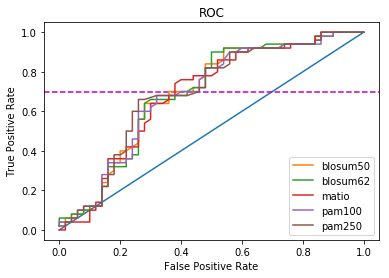

In [136]:
matrices = [blosum50,blosum62,matio,pam100,pam250]
matrix_names = ['blosum50','blosum62','matio','pam100','pam250']
score_list = [] #Combined negative and positive scores as numpy array
true_pos = [1]*50 # ture_pos = [1]*len(pos)
true_neg = [0]*50 # ture_neg = [0]*len(neg)
combined_trues = np.concatenate((true_pos,true_neg)) #Telling sckit-roc curve which are pos, which are neg

for m in matrices: 
    pos_align_score =[]
    neg_align_score = []
    for i in range(0,len(pospairs1)):
        mat_score_p,mat_state_p, score_p, state_p = align(pospairs1[i],pospairs2[i], -best_gap ,-best_extension, m)
        mat_score_n,mat_state_n, score_n, state_n = align(negpairs1[i],negpairs2[i], -best_gap ,-best_extension, m)
        pos_align_score.append(score_p)
        neg_align_score.append(score_n)    
    score_list.append(np.concatenate((np.asarray(pos_align_score), np.asarray(neg_align_score))))

plt.figure()
plt.plot([0,1],[0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.axhline(0.7, color = 'm', linestyle = '--')
for score, label in zip(score_list, matrix_names):
    fpr,tpr, treshold = roc_curve(combined_trues,score, pos_label=1)
    plt.plot(fpr, tpr, label=label)
plt.legend()
plt.show()
plt.close()

# Normalize SW score with shortest sequence length

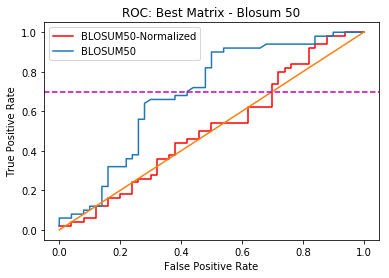

In [161]:
norm_pos_score, norm_neg_score = [], []
for i in range(0,len(pospairs1)):
    mat_score_p,mat_state_p, score_p, state_p = align(pospairs1[i],pospairs2[i], -best_gap ,-best_extension, blosum50)
    mat_score_n,mat_state_n, score_n, state_n = align(negpairs1[i],negpairs2[i], -best_gap ,-best_extension, blosum50)
    norm_pos = score_p/min(len(pospairs1[i]),len(pospairs2[i]))
    norm_neg = score_n/min(len(negpairs1[i]),len(negpairs2[i]))
    norm_pos_score.append(norm_pos)
    norm_neg_score.append(norm_neg)

norm_pos_np = np.asarray(norm_pos_score)
norm_neg_np = np.asarray(norm_neg_score)
norm_combined = np.concatenate((norm_pos_np,norm_neg_np))
norm_true_pos = [1]*len(norm_pos_score)
norm_true_neg = [0]*len(norm_neg_score)
norm_combined_trues = np.concatenate((norm_true_pos,norm_true_neg))

norm_fpr,norm_tpr, treshold = roc_curve(norm_combined_trues,norm_combined, pos_label=1) #This is for normalized ROC
fpr,tpr, treshold = roc_curve(combined_trues,score_list[1], pos_label=1) # This is for regular ROC
plt.figure()
plt.plot(norm_fpr,norm_tpr, 'r', label = 'BLOSUM50-Normalized')
plt.plot(fpr, tpr, label = 'BLOSUM50')
plt.plot([0,1],[0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC: Best Matrix - Blosum 50")
plt.axhline(0.7, color = 'm', linestyle = '--')
plt.show()
plt.close()

# Optimization

In [138]:
def obj_fun(pos, neg):
    '''
    return sum of TP rates for FP rates of 0.0, 0.1, 0.2, and 0.3.
    '''

    fp = []
    tp = []

    for t in [0.0,0.1,0.2,0.3]:
        thresh = np.percentile(neg, 100*(1-t))
        false_positives = [i for i in neg if i > thresh]
        fpr = len(false_positives)/float(len(neg))
        true_positives = [i for i in pos if i > thresh]
        tpr = len(true_positives)/float(len(pos))
        tp.append(tpr)
        fp.append(fpr)

    return(sum(tp))

In [154]:
def new_matrix(matrices):
    '''
    Randomoly switches indices of original scoring matrix. (i.e. giving amino acids new scores.)
    Return 5 new matrices. 
    '''
    new_matrices = []
    for m in matrices: 
        new_mat = m.copy()
        a,b,c,d = np.random.choice(range(len(m.columns)), 4)
        index = list(m.columns)
        index[a], index[b], index[c], index[d]= index[d], index[a], index[b], index[c]
        new_mat.columns = index
        new_mat.index = index
        new_matrices.append(new_mat)
    return new_matrices 

At matrix   A  R  N  D   C  Q  E  G   L  I ...   P  S  T   W  Z  V  B  H  X  *
A  5 -2 -1 -2  -1 -1 -1  0  -2 -1 ...  -1  1  0  -3 -2  0 -2 -1 -1 -5
R -2  7 -1 -2  -4  1  0 -3   0 -4 ...  -3 -1 -1  -3 -1 -3 -1  0 -1 -5
N -1 -1  7  2  -2  0  0  0   1 -3 ...  -2  1  0  -4 -2 -3  4  0 -1 -5
D -2 -2  2  8  -4  0  2 -1  -1 -4 ...  -1  0 -1  -5 -3 -4  5  1 -1 -5
C -1 -4 -2 -4  13 -3 -3 -3  -3 -2 ...  -4 -1 -1  -5 -3 -1 -3 -3 -2 -5
Q -1  1  0  0  -3  7  2 -2   1 -3 ...  -1  0 -1  -1 -1 -3  0  4 -1 -5
E -1  0  0  2  -3  2  6 -3   0 -4 ...  -1 -1 -1  -3 -2 -3  1  5 -1 -5
G  0 -3  0 -1  -3 -2 -3  8  -2 -4 ...  -2  0 -2  -3 -3 -4 -1 -2 -2 -5
L -2  0  1 -1  -3  1  0 -2  10 -4 ...  -2 -1 -2  -3  2 -4  0  0 -1 -5
I -1 -4 -3 -4  -2 -3 -4 -4  -4  5 ...  -3 -3 -1  -3 -1  4 -4 -3 -1 -5
Y -2 -3 -4 -4  -2 -2 -3 -4  -3  2 ...  -4 -3 -1  -2 -1  1 -4 -3 -1 -5
K -1  3  0 -1  -3  2  1 -2   0 -3 ...  -1  0 -1  -3 -2 -3  0  1 -1 -5
M -1 -2 -2 -4  -2  0 -2 -3  -1  2 ...  -3 -2 -1  -1  0  1 -3 -1 -1 -5
F -3 -3 -4 

At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At score!
At matrix   A  R  N  D   C  Q  H  E  L  I ...  P  S  T   W   Y  V  B  Z  X  *
A  2 -2  0  0  -2  0  0  1 -1 -1 ...  1  1  1  -6  -3  0  0  0  0 -8
R -2  6  0 -1  -4  1 -1 -3  2 -2 ...  0  0 -1   2  -4 -2 -1  0 -1 -8
N  0  0  2  2  -4  1  1  0  2 -2 ...  0  1  0  -4  -2 -2  2  1  0 -8
D  0 -1  2  4  -5  2  3  1  1 -2 ... -1  0  0  -7  -4 -2  3  3 -1 -8
C -2 -4 -4 -5  12 -5 -5 -3 -3 -2 ... -3  0 -2  -8   0 -2 -4 -5 -3 -8
Q  0  1  1  2  -5  4  2 -1  3 -2 ...  0 -1 -1  -5  -4 -2  1  3 -1 -8
H  0 -1 

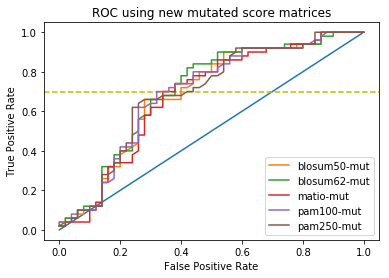

In [155]:
new_matrix_names= ['blosum50-mut','blosum62-mut','matio-mut','pam100-mut','pam250-mut']
new_score_list = [] #Combined negative and positive scores as numpy array
new_true_pos= [1]*50 # ture_pos = [1]*len(pos)
new_true_neg= [0]*50 # ture_neg = [0]*len(neg)
new_combined_trues= np.concatenate((new_true_pos,new_true_neg)) #Telling sckit-roc curve which are pos, which are neg
obj_sum_tps= [] #For calculating sum of tps using objective function
max_fitness = 0 # To calculate max fitness
for m in new_matrix(matrices): 
    new_pos_align_score =[]
    new_neg_align_score = []
    print ('At matrix' + str(m))
    for i in range(0,len(pospairs1)):
        mat_score_p,mat_state_p, new_score_p, state_p = align(pospairs1[i],pospairs2[i], -best_gap ,-best_extension, m)
        mat_score_n,mat_state_n, new_score_n, state_n = align(negpairs1[i],negpairs2[i], -best_gap ,-best_extension, m)

        new_pos_align_score.append(new_score_p)
        new_neg_align_score.append(new_score_n)
        print('At score!')
        sum_tps = obj_fun(new_pos_align_score, new_neg_align_score)
        obj_sum_tps.append(sum_tps)
        if sum_tps > max_fitness:
            max_fitness = sum_tps
            print ('calculated Max Fitness!')
    new_score_list.append(np.concatenate((np.asarray(new_pos_align_score), np.asarray(new_neg_align_score))))

plt.figure()
plt.plot([0,1],[0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC using new mutated score matrices")
plt.axhline(0.7, color = 'y', linestyle = '--')
for new_score, new_label in zip(new_score_list, new_matrix_names):
    new_fpr,new_tpr, treshold = roc_curve(new_combined_trues,new_score, pos_label=1)
    plt.plot(new_fpr, new_tpr, label=new_label)
plt.legend()
plt.show()
plt.close()

In [156]:
new_mat = new_matrix(matrices)

In [157]:
blosum50_mut = pd.DataFrame(new_mat[0])
blosum62_mut = pd.DataFrame(new_mat[1])
matio_mut = pd.DataFrame(new_mat[2])
pam100_mut = pd.DataFrame(new_mat[3])
pam250_mut = pd.DataFrame(new_mat[4])

In [158]:
blosum50_mut.to_csv('blosum50-mut.txt', index=True, sep=' ', header=True)
blosum62_mut.to_csv('blosum62-mut.txt', index=True, sep=' ', header=True)
matio_mut.to_csv('matio_mut.txt', index=True, sep=' ', header=True)
pam100_mut.to_csv('pam100-mut.txt', index=True, sep=' ', header=True)
pam250_mut.to_csv('pam250-mut.txt', index=True, sep=' ', header=True)

In [193]:
blosum50

,A,R,N,D,C,Q,E,G,H,I,...,P,S,T,W,Y,V,B,Z,X,*
0,,,,,,,,,,,,,,,,,,,,,
A,5,-2,-1,-2,-1,-1,-1,0,-2,-1,...,-1,1,0,-3,-2,0,-2,-1,-1,-5
R,-2,7,-1,-2,-4,1,0,-3,0,-4,...,-3,-1,-1,-3,-1,-3,-1,0,-1,-5
N,-1,-1,7,2,-2,0,0,0,1,-3,...,-2,1,0,-4,-2,-3,4,0,-1,-5
D,-2,-2,2,8,-4,0,2,-1,-1,-4,...,-1,0,-1,-5,-3,-4,5,1,-1,-5
C,-1,-4,-2,-4,13,-3,-3,-3,-3,-2,...,-4,-1,-1,-5,-3,-1,-3,-3,-2,-5
Q,-1,1,0,0,-3,7,2,-2,1,-3,...,-1,0,-1,-1,-1,-3,0,4,-1,-5
E,-1,0,0,2,-3,2,6,-3,0,-4,...,-1,-1,-1,-3,-2,-3,1,5,-1,-5
G,0,-3,0,-1,-3,-2,-3,8,-2,-4,...,-2,0,-2,-3,-3,-4,-1,-2,-2,-5
H,-2,0,1,-1,-3,1,0,-2,10,-4,...,-2,-1,-2,-3,2,-4,0,0,-1,-5


In [201]:

df=pd.read_csv('../matrices_mut/pam100-mut.txt', sep=' ', header=0)
df = df.set_index('Unnamed: 0')
